In [40]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Metropolis Monte-Carlo implementation of Ising model

**Add some info/diagram about metropolis algorithm!!**

In [ ]:
# General metropolis algorithm for Ising model.
class MetropolisIsing:
    """ 
    Implementation of Ising model, i.e. nearest-neighbor (nn) interactions, 
    using a vectorized Metropolis Monte-Carlo (MC) algorithm.
    Works for binary spin configuration on a 1d chain, 2d lattice, and Cayley graph.
    """
    def __init__(self, T, J=1.0, H=0.0):
        """
        Args:
            T (float): temperature
            J (float): strength of nearest neighbor interactions
            H (float): strength of external magnetic field
        """
        self.beta = 1 / T   # Set Boltzmann constant to 1.
        self.J = J
        self.H = H
    
    def nn_alignment(self):
        """ 
        Must be implemented in child classes.
        Intended to return net alignment of the nearest-neighbor (nn) spins, 
        using periodic boundary conditions.
        """
        raise NotImplementedError("Function must be called from a child class.")
    
    def update_spins(self, X_spins):
        """ 
        Update spins in the lattice using metropolis algorithm.
        Args:
            X_spins (1d or 2d array): current state of the spin system
        
        Returns:
            X_result (1d or 2d array): updated state of the spin system
        """
        # Calculate change in energy required to flip each spin.
        X_nn = self.nn_alignment(X_spins)
        X_Ei = - self.J * X_spins * X_nn - self.H * X_spins
        X_Ef = - X_Ei
        X_deltaE = X_Ef - X_Ei

        X_result = X_spins.copy()
        X_flip = - X_spins

        # If deltaE < 0, accept the spin flip.
        X_result[X_deltaE < 0] = X_flip[X_deltaE < 0]

        # If deltaE > 0, accept the spin flip with probability
        # given by Boltzmann factor.
        X_prob = np.random.rand(*X_spins.shape)
        X_prob_c = np.exp(- self.beta * X_deltaE)
        X_result[(X_deltaE > 0) & (X_prob < X_prob_c)] = X_flip[
            (X_deltaE > 0) & (X_prob < X_prob_c)]

        return X_result
    
    def net_magnetization(self, X_spins):
        """ 
        Calculate net magnetization of the spin system. This is simply the sum
        of all spin values in the lattice.
        Args:
            X_spins (1d or 2d array): current state of the spin system
        
        Returns:
            (float): net magnetization
        """
        return np.sum(X_spins)
    
    def net_energy(self, X_spins):
        """ 
        Calculate net energy of the spin lattice. This is the sum of all energies
        due to nn interactions and the external magnetic field.
        Args:
            X_spins (1d or 2d array): current state of the spin system
        
        Returns:
            (float): net energy
        """
        X_nn = self.nn_alignment(X_spins)
        X_E = -self.J * X_spins * X_nn - self.H * X_spins
        return np.sum(X_E)


# Ising model on 1D chain

In [ ]:
class Ising1D(MetropolisIsing):
    """ 
    Metrpopolis MC implementation of Ising model on 1d spin chain.
    """
    def nn_alignment(self, X_chain):
        """ 
        Sum the spin values of the 2 nearest neighbors (nn) for each spin in
        the lattice. This represents the net alignment of the nn spins.
        Args:
            X_chain (1darray): current state of the spin system

        Returns:
            X_nn (1darray): sum of nn spin values
        """
        X_nn = np.zeros_like(X_chain)
        X_nn[:-1] += X_chain[1:]           # Left neighbor contribution
        X_nn[1:]  += X_chain[:-1]          # Right neighbor contribution

        # Periodic boundary conditions.
        X_nn[-1] += X_chain[0]
        X_nn[0] += X_chain[-1]

        return X_nn

iterations: 5


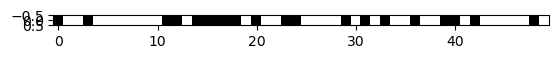

In [43]:
np.random.seed(0)
frames = []
size = 50
chain1d = np.random.choice([-1, 1], size=size)
array1d = chain1d.reshape(1, -1)
frames.append(array1d)

Ising1d = Ising1D(T=0.01, J=1, H=0.1)
fig = plt.figure()
img = plt.imshow(array1d, cmap="gray")

for i in range(50):
    chain1d = Ising1d.update_spins(chain1d)
    array1d = chain1d.reshape(1, -1)
    frames.append(array1d)
    if np.all(chain1d == 1):
        break
print("iterations:", i + 1)

def animate(frame):
    img.set_array(frame)

animation = FuncAnimation(fig, animate, frames=frames, interval=len(frames))
HTML(animation.to_jshtml())

---
# Ising model on 2D lattice

In [ ]:
class Ising2DLattice(MetropolisIsing):
    """ 
    Metropolis MC implementation of Ising model on a 2D lattice.
    """
    def nn_alignment(self, X_lattice):
        """ 
        Sum the spin values of the 4 nearest neighbors (nn) for each spin in
        the lattice. This represents the net alignment of the nn spins.
        Args:
            X_lattice (2darray): current state of the spin system

        Returns:
            X_nn (2darray): sum of nn spin values
        """
        X_nn = np.zeros_like(X_lattice)
        X_nn[:, :-1] += X_lattice[:, 1:]    # Left nn contribution
        X_nn[:, 1:] += X_lattice[:, :-1]    # Right nn contribution
        X_nn[:-1, :] += X_lattice[1:, :]    # Lower nn contribution
        X_nn[1:, :] += X_lattice[:-1, :]    # Upper nn contribution

        # Periodic boundary conditions
        X_nn[:, 0] += X_lattice[:, -1]      # Right-end to left-end
        X_nn[:, -1] += X_lattice[:, 0]      # Left-end to right-end
        X_nn[0, :] += X_lattice[-1, :]      # Bottom-end to top-end
        X_nn[-1, :] += X_lattice[-1, :]     # Top-end to bottom-end

        return X_nn


iterations: 7


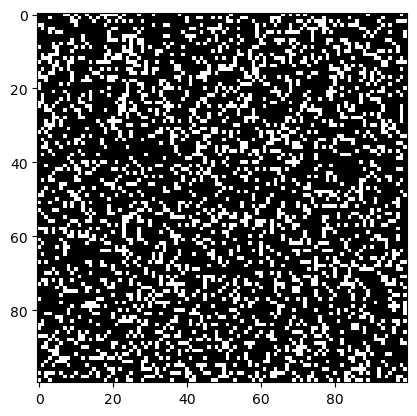

In [ ]:
# Simulate time evolution of a 2D Ising model with nn interactions.
Ising2d = Ising2DLattice(T=0.1, J=1, H=0.0)
np.random.seed(0)

frames = []
dim = 100
lattice2d = np.random.choice([-1, 1], size=(dim, dim), p=[0.75, 0.25])
frames.append(lattice2d)
fig = plt.figure()
img = plt.imshow(lattice2d, cmap="gray")

iterations = 200
prev = lattice2d
for i in range(iterations):
    current = Ising2d.update_spins(prev)
    frames.append(current)
    if np.array_equal(current, prev):
        break
    prev = current
print("iterations:", i + 1)

# Animate the simulation.
def animate(frame):
    img.set_array(frame)

animation = FuncAnimation(fig, animate, frames=frames, interval=len(frames))
HTML(animation.to_jshtml())

C:\Users\ktcy2\AppData\Local\Temp\ipykernel_2420\2812931362.py:15: RuntimeWarning: divide by zero encountered in scalar divide
  self.beta = 1 / T   # Set Boltzmann constant to 1.
C:\Users\ktcy2\AppData\Local\Temp\ipykernel_2420\2812931362.py:51: RuntimeWarning: invalid value encountered in multiply
  X_prob_c = np.exp(- self.beta * X_deltaE)


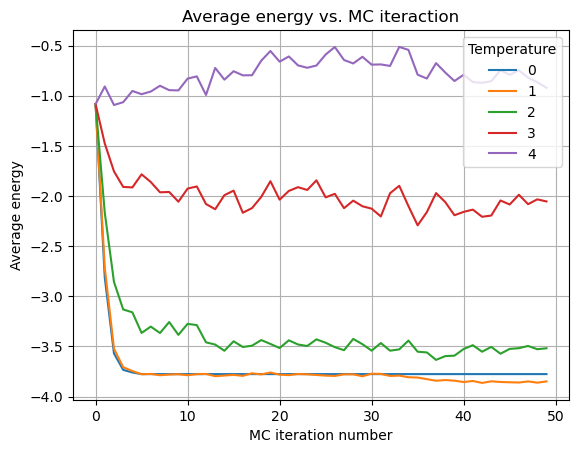

In [54]:
# Plot average energy vs MC iteration for various temperatures.
temps = np.arange(0, 5, 1)
total_iter = 50
all_iter = []
all_energies = []
dim = 50
lattice2d = np.random.choice([-1, 1], size=(dim, dim), p=[0.75, 0.25])

for temp in temps:
    Ising2d = Ising2DLattice(T=temp, J=1, H=0.0)
    np.random.seed(0)
    iteration = np.arange(0, total_iter)
    avg_energy = []

    prev = lattice2d
    for i in range(total_iter):
        current = Ising2d.update_spins(prev)
        avg_energy.append(Ising2d.net_energy(prev) / dim ** 2)
        prev = current

    all_iter.append(iteration)
    all_energies.append(avg_energy)

plt.figure()
for i in range(len(all_iter)):
    temp = temps[i]
    plt.plot(all_iter[i], all_energies[i], label=str(temp))

plt.xlabel('MC iteration number')
plt.ylabel('Average energy')
plt.title('Average energy vs. MC iteraction')
plt.grid()
plt.legend(title="Temperature")
plt.show()

C:\Users\ktcy2\AppData\Local\Temp\ipykernel_2420\2812931362.py:51: RuntimeWarning: overflow encountered in exp
  X_prob_c = np.exp(- self.beta * X_deltaE)


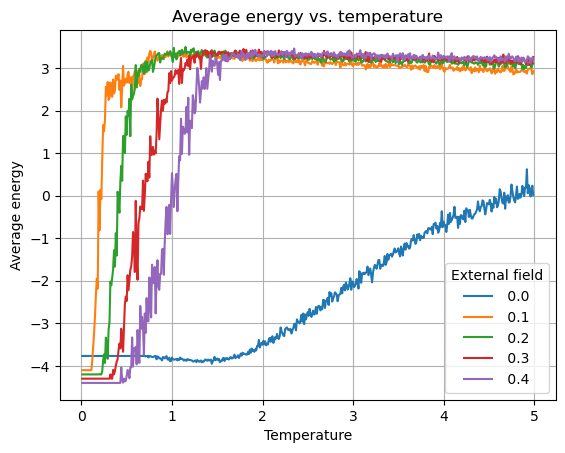

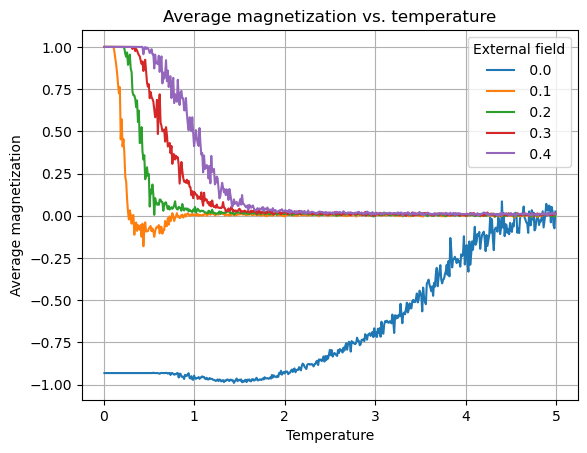

In [55]:
# Plot equilibrium average energy and magnetization vs temperature for various 
# external field strengths.
ext_field = np.arange(0.0, 0.5, 0.1)
temps = np.arange(0.01, 5., 0.01)
total_iter = 50
l_all_energies, l_all_mag = [], []
dim = 50

for field_val in ext_field:
    np.random.seed(0)
    lattice2d = np.random.choice([-1, 1], size=(dim, dim), p=[0.75, 0.25])
    l_energy, l_mag = [], []

    for temp in temps:
        Ising2d = Ising2DLattice(T=temp, J=1, H=field_val)
        prev = lattice2d
        for _ in range(total_iter):
            current = Ising2d.update_spins(prev)
            if np.array_equal(current, prev):
                break
            prev = current

        avg_energy = Ising2d.net_energy(current) / dim ** 2
        avg_mag = Ising2d.net_magnetization(current) / dim ** 2
        l_energy.append(avg_energy)
        l_mag.append(avg_mag)

    l_all_energies.append(l_energy)
    l_all_mag.append(l_mag)

plt.figure()
for i, field_val in enumerate(ext_field):
    plt.plot(temps, l_all_energies[i], label=f"{field_val: .1f}")
plt.xlabel('Temperature')
plt.ylabel('Average energy')
plt.title('Average energy vs. temperature')
plt.grid()
plt.legend(title="External field")
plt.show()

plt.figure()
for i, field_val in enumerate(ext_field):
    plt.plot(temps, l_all_mag[i], label=f"{field_val: .1f}")
plt.xlabel('Temperature')
plt.ylabel('Average magnetization')
plt.title('Average magnetization vs. temperature')
plt.grid()
plt.legend(title="External field")
plt.show()

---
# Ising model on Cayley graph

In [63]:
class IsingCayley(MetropolisIsing):
    """ 
    Metropolis MC implementation of Ising model on a Cayley graph.
    """
    def nn_alignment(self, v_spins, X_neighbors):
        """ 
        Sum the spin values of the nearest neighbors (nn) for each spin in
        the Cayley graph. This represents the net alignment of the nn spins. 
        Args:
            v_spins (1d array): current state of the spin system
            X_neighbors (2d array): adjacency matrix denoting all edges between spins

        Returns:
            v_nn (1d array): sum of nn spin values
        """
        v_nn = np.ones_like(v_spins)
        v_nn = X_neighbors @ v_nn
        return v_nn
    
    def update_spins(self, v_spins, X_neighbors):
        """ 
        Update spins in the lattice using metropolis algorithm.
        Args:
            v_spins (1d array): current state of the spin system
            X_neighbors (2d array): adjacency matrix denoting all edges between spins
        
        Returns:
            X_result (2d array): updated state of the spin system
        """
        # Calculate change in energy required to flip each spin.
        X_nn = self.nn_alignment(v_spins, X_neighbors)
        X_Ei = - self.J * v_spins * X_nn - self.H * v_spins
        X_Ef = - X_Ei
        X_deltaE = X_Ef - X_Ei

        X_result = v_spins.copy()
        X_flip = - v_spins

        # If deltaE < 0, accept the spin flip.
        X_result[X_deltaE < 0] = X_flip[X_deltaE < 0]

        # If deltaE > 0, accept the spin flip with probability
        # given by Boltzmann factor.
        X_prob = np.random.rand(*v_spins.shape)
        X_prob_c = np.exp(- self.beta * X_deltaE)
        X_result[(X_deltaE > 0) & (X_prob < X_prob_c)] = X_flip[
            (X_deltaE > 0) & (X_prob < X_prob_c)]

        return X_result
    
    def net_energy(self, v_spins, X_neighbors):
        """ 
        Calculate net energy of the spin lattice. This is the sum of all energies
        due to nn interactions and the external magnetic field.
        Args:
            v_spins (2d array): current state of the spin system
            X_neighbors (2d array): adjacency matrix denoting all edges between spins
        
        Returns:
            (float): net energy
        """
        X_nn = self.nn_alignment(v_spins, X_neighbors)
        X_E = -self.J * v_spins * X_nn - self.H * v_spins
        return np.sum(X_E)



iterations: 13


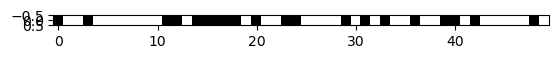

In [64]:
# Change this to visualize the tree in 2d instead of using a chain !!

IsingCayley = IsingCayley(T=30, J=1, H=0.0)
np.random.seed(0)

frames = []
dim = 50
v_spins = np.random.choice([-1, 1], size=dim)
v_spins_reshape = v_spins.reshape(1, -1)
# Every spin is connected to every other spin.
X_adjacency = np.ones((dim, dim))
np.fill_diagonal(X_adjacency, 0)

frames.append(v_spins_reshape)
fig = plt.figure()
img = plt.imshow(v_spins_reshape, cmap="gray")

iterations = 200
prev = v_spins
for i in range(iterations):
    current = IsingCayley.update_spins(prev, X_adjacency)
    current_reshape = current.reshape(1, -1)
    frames.append(current_reshape)
    if np.array_equal(current, prev):
        break
    prev = current
print("iterations:", i + 1)

# Animate the simulation.
def animate(frame):
    img.set_array(frame)

animation = FuncAnimation(fig, animate, frames=frames, interval=len(frames))
HTML(animation.to_jshtml())

In [65]:
mag = IsingCayley.net_magnetization(current)
energy = IsingCayley.net_energy(current, X_adjacency)

print(mag, energy)

50 -2450.0
